# Отток клиентов

### Цель проекта: построить модель с предельно большим значением F1-меры

### Описание проекта:

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. С помощью предоставленных исторических данных о поведении клиентов и расторжении договоров с банком необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<h1>Содержание:<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Финальное-тестирование" data-toc-modified-id="Финальное-тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Финальное тестирование</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Подготовка данных

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Загружаем данные из файла в датафрейм

try:    
    data = pd.read_csv('Downloads/Churn.csv')
    
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
# Изучим данные

display(data.head())
data.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data['Tenure'].isna().sum()

909

In [5]:
data.duplicated().sum()

0

В датафрейме 10000 строк, 14 столбцов. В столбце Tenure имеются пропуски. Приведем названия столбцов к нижнему регистру и обработаем пропуски.

In [6]:
data.columns = data.columns.str.lower()
data.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
print(data['tenure'].corr(data['exited']))

-0.01676148151493379


Отток клиентов не зависит от того, сколько лет они пользуются услугами банка. Это значит, что мы можем заполнить пропуски в столбце Tenure или удалить их. Заполним пропуски медианными значениями и приведем данные в столбце к целочисленному типу. 

In [8]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())
data['tenure'] = data['tenure'].astype(int)

In [9]:
# data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Фамилии клиентов, их id и номер строки - это данные, которые не влияют на поведение клиентов, поэтому их можно удалить. 

In [10]:
# Удалим столбцы с данными, которые не влияют на отток клиентов

data = data.drop(columns =['rownumber', 'customerid', 'surname'], axis = 1)

In [12]:
# Обработка категориальных признаков методом One-Hot Encoding и разделение данных на обучающую, валидационную и тестовую выборки

rndm = 12345

data_train_ohe, data_test_ohe = train_test_split(data, test_size=0.4, random_state=rndm)
data_test_ohe, data_valid_ohe = train_test_split(data_test_ohe, test_size=0.5, random_state=rndm)
cat_features = ['geography', 'gender']

ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)

train_temp = ohe_encoder.fit_transform(data_train_ohe[cat_features])
data_train_ohe[ohe_encoder.get_feature_names_out()] = train_temp
data_train_ohe.drop(cat_features, axis = 1, inplace=True)

test_temp = ohe_encoder.fit_transform(data_test_ohe[cat_features])
data_test_ohe[ohe_encoder.get_feature_names_out()] = test_temp
data_test_ohe.drop(cat_features, axis = 1, inplace=True)

valid_temp = ohe_encoder.fit_transform(data_valid_ohe[cat_features])
data_valid_ohe[ohe_encoder.get_feature_names_out()] = valid_temp
data_valid_ohe.drop(cat_features, axis = 1, inplace=True)

data_test_ohe.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
8532,585,35,2,0.00,2,1,0,98621.04,1,0.0,0.0,0.0
5799,625,45,3,0.00,1,1,1,184474.15,1,0.0,0.0,0.0
5511,667,32,0,103846.65,1,1,0,20560.69,0,1.0,0.0,1.0
7365,568,36,10,153610.61,1,1,1,54083.80,1,0.0,1.0,0.0
7367,606,42,10,0.00,2,1,0,177938.52,0,0.0,1.0,1.0


In [13]:
print('Размер обучающей выборки:', len(data_train_ohe), 'строк')
print('Размер валидационной выборки:', len(data_valid_ohe), 'строки')
print('Размер тестовой выборки:', len(data_test_ohe), 'строки')

Размер обучающей выборки: 6000 строк
Размер валидационной выборки: 2000 строки
Размер тестовой выборки: 2000 строки


В результате подготовки данных были заполнены пропуски, дубликатов не обнаружено. Названия столбцов приведены к нижнему регистру, ненужные для настоящего исследования столбцы были удалены. Категориальные признаки обработаны техникой One-Hot Encoding

## Исследование задачи

In [14]:
# Извлекаем признаки и целевой признак

features_train = data_train_ohe.drop(['exited'], axis = 1)
features_valid = data_valid_ohe.drop(['exited'], axis = 1)
features_test = data_test_ohe.drop(['exited'], axis = 1)

target_train = data_train_ohe['exited']
target_valid = data_valid_ohe['exited']
target_test = data_test_ohe['exited']

In [15]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7479,567,35,8,153137.74,1,1,0,88659.07,0.0,1.0,1.0
3411,711,37,8,113899.92,1,0,0,80215.20,0.0,0.0,0.0
6027,850,44,3,140393.65,2,0,1,186285.52,1.0,0.0,1.0
1247,512,24,6,0.00,2,1,0,37654.31,0.0,0.0,1.0
3716,665,27,2,147435.96,1,0,0,187508.06,1.0,0.0,0.0


In [16]:
# Чтобы алгоритмам было легче обучать модели, приведем признаки к одному масштабу

numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts','estimatedsalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [17]:
features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0.0,1.0,1.0
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0.0,0.0,0.0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1.0,0.0,1.0
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0.0,0.0,1.0
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1.0,0.0,0.0


Обучим модели дерева решений, случайного леса и логистической регрессии. Посмотрим на матрицу ошибок, точность, f1-меру и AUC-ROC у обученных моделей. 

In [18]:
# Decision Tree

best_model_tree = None
best_result = 0
best_depth = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state = rndm, max_depth = depth)
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid) 
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model_tree = model
        best_result = result
        best_depth = depth
        
print('Наилучший показатель F1-меры:', best_result)
print('Глубина дерева с наилучшими показателями:', best_depth)

Наилучший показатель F1-меры: 0.5337423312883436
Глубина дерева с наилучшими показателями: 6


In [19]:
predicted_valid = best_model_tree.predict(features_valid)
probabilities_valid = best_model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC равен', roc_auc_score(target_valid, probabilities_one_valid))

Матрица ошибок:
[[1522   55]
 [ 249  174]]
Accuracy: 0.848
F1-мера: 0.5337423312883436
AUC-ROC равен 0.8394526219847661


Модель выглядит адекватно, однако результат нас не устраивает. 

In [20]:
# Random Forest

best_depth = 0
best_f1_score = 0

for depth in range(1, 31, 1):
    model = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = rndm)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result_1 = f1_score(target_valid, predicted_valid)
    print(f'depth = {depth}')
    print(result_1)
    if result_1 > best_f1_score:
        best_depth = depth
        best_f1_score = result_1
        
print(f'Лучший результат F1-меры = {best_f1_score}, при depth = {best_depth}')

depth = 1
0.0
depth = 2
0.12831858407079647
depth = 3
0.2125
depth = 4
0.31178707224334606
depth = 5
0.42980935875216636
depth = 6
0.4478114478114478
depth = 7
0.48231511254019294
depth = 8
0.48553054662379413
depth = 9
0.5111111111111111
depth = 10
0.5202492211838007
depth = 11
0.5155279503105591
depth = 12
0.5155279503105591
depth = 13
0.529500756429652
depth = 14
0.5319148936170214
depth = 15
0.5317220543806647
depth = 16
0.5355521936459909
depth = 17
0.5311077389984825
depth = 18
0.5282442748091603
depth = 19
0.5383458646616541
depth = 20
0.5413533834586466
depth = 21
0.5288753799392097
depth = 22
0.5547226386806597
depth = 23
0.5590433482810165
depth = 24
0.5611940298507463
depth = 25
0.5527488855869243
depth = 26
0.5527488855869243
depth = 27
0.5527488855869243
depth = 28
0.5527488855869243
depth = 29
0.5527488855869243
depth = 30
0.5527488855869243
Лучший результат F1-меры = 0.5611940298507463, при depth = 24


In [21]:
best_est = 0
best_f1_score_2 = 0

for est in range(10, 151, 10):
    model = RandomForestClassifier(n_estimators = est, max_depth = best_depth, random_state = rndm)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1_score_2 = f1_score(target_valid, predicted_valid)
    print(f'n_est = {est}')
    print(f1_score_2)
    if f1_score_2 > best_f1_score_2:
        best_est = est
        best_f1_score_2 = f1_score_2
print(f'Лучший результат F1-меры = {best_f1_score_2}, при n_est = {best_est}')

n_est = 10
0.5007727975270478
n_est = 20
0.5259938837920489
n_est = 30
0.5429864253393666
n_est = 40
0.5288753799392097
n_est = 50
0.5411061285500747
n_est = 60
0.5405405405405406
n_est = 70
0.5451807228915663
n_est = 80
0.5479041916167665
n_est = 90
0.562874251497006
n_est = 100
0.5611940298507463
n_est = 110
0.542728635682159
n_est = 120
0.5500747384155455
n_est = 130
0.5582089552238806
n_est = 140
0.5479041916167665
n_est = 150
0.5397301349325337
Лучший результат F1-меры = 0.562874251497006, при n_est = 90


In [22]:
best_model_rfc = RandomForestClassifier(n_estimators = 90, max_depth = 24, random_state = rndm)
best_model_rfc.fit(features_train, target_train)
predicted_valid = best_model_rfc.predict(features_valid)
probabilities_valid = best_model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

Матрица ошибок:
[[1520   57]
 [ 235  188]]
Accuracy: 0.854
F1-мера: 0.562874251497006
AUC-ROC: 0.8498345753300622


Модель случайного леса показывает себя чуть лучше модели решающего дерева, но результат нас все еще не устраивает. 

In [23]:
# Logistic Regression

model_lr = LogisticRegression(random_state=rndm, solver='liblinear')
model_lr.fit(features_train, target_train)

# Переберем значения порогов и найдем для каждого значения точность, полноту, F1-меру и AUC-ROC

probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, roc_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)))


Порог = 0.00 | Точность = 0.211, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.02 | Точность = 0.213, Полнота = 0.991, F1 = 0.350, roc_auc = 0.504
Порог = 0.04 | Точность = 0.225, Полнота = 0.972, F1 = 0.365, roc_auc = 0.536
Порог = 0.06 | Точность = 0.243, Полнота = 0.939, F1 = 0.385, roc_auc = 0.576
Порог = 0.08 | Точность = 0.264, Полнота = 0.920, F1 = 0.410, roc_auc = 0.616
Порог = 0.10 | Точность = 0.285, Полнота = 0.884, F1 = 0.432, roc_auc = 0.645
Порог = 0.12 | Точность = 0.302, Полнота = 0.842, F1 = 0.444, roc_auc = 0.660
Порог = 0.14 | Точность = 0.321, Полнота = 0.813, F1 = 0.461, roc_auc = 0.676
Порог = 0.16 | Точность = 0.343, Полнота = 0.766, F1 = 0.474, roc_auc = 0.686
Порог = 0.18 | Точность = 0.362, Полнота = 0.714, F1 = 0.480, roc_auc = 0.688
Порог = 0.20 | Точность = 0.371, Полнота = 0.660, F1 = 0.475, roc_auc = 0.680
Порог = 0.22 | Точность = 0.382, Полнота = 0.608, F1 = 0.469, roc_auc = 0.672
Порог = 0.24 | Точность = 0.394, Полнота = 0.574, F1 = 0.468, ro

Модель логистической регрессии показывает результат хуже остальных. Максимальное значение F1-меры равно 0.48, AUC-ROC равно 0.688 при пороге 0.18.

**Вывод:**

На данном этапе лучше всех себя показывает модель случайного леса. Ее accuracy равна 0.854, f1-score равна 0.562, auc-roc равна 0.84

## Борьба с дисбалансом

In [24]:
# Изучим соотношение классов

print(target_train.value_counts(normalize = 1))

0    0.800667
1    0.199333
Name: exited, dtype: float64


Объектов отрицательного класса в 4 раза больше. Для борьбы с таким дисбалансом применим несколько техник: параметр class_weight, а также увеличение и уменьшение выборки - upsampling и downsampling.

Начнем с применения параметра class_weight к базовым моделям:

In [25]:
# Decision Tree Balanced

best_model_tree_balanced = None
best_result = 0
best_depth = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state = rndm, max_depth = depth, class_weight='balanced')
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid) 
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model_tree_balanced = model
        best_result = result
        best_depth = depth
        
print('Наилучший показатель F1-меры:', best_result)
print('Глубина дерева с наилучшими показателями:', best_depth)

Наилучший показатель F1-меры: 0.5809128630705395
Глубина дерева с наилучшими показателями: 5


In [26]:
predicted_valid = best_model_tree_balanced.predict(features_valid)
probabilities_valid = best_model_tree_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC', roc_auc_score(target_valid, probabilities_one_valid))

Матрица ошибок:
[[1316  261]
 [ 143  280]]
Accuracy: 0.798
F1-мера: 0.5809128630705395
AUC-ROC 0.8355347481752318


Качество модели улучшилось, но нужный результат не достигнут. 

In [27]:
# Random Forest Balanced

best_depth = 0
best_f1_score = 0

for depth in range(1, 31, 1):
    model = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = rndm, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result_1 = f1_score(target_valid, predicted_valid)
    print(f'depth = {depth}')
    print(result_1)
    if result_1 > best_f1_score:
        best_depth = depth
        best_f1_score = result_1
        
print(f'Лучший результат F1-меры = {best_f1_score}, при depth = {best_depth}')


depth = 1
0.5215004574565416
depth = 2
0.5538178472861085
depth = 3
0.563302752293578
depth = 4
0.5840537944284342
depth = 5
0.5936883629191321
depth = 6
0.5971943887775552
depth = 7
0.6134715025906735
depth = 8
0.6105717367853291
depth = 9
0.6115515288788221
depth = 10
0.6166666666666667
depth = 11
0.6032953105196451
depth = 12
0.5733695652173914
depth = 13
0.5953360768175583
depth = 14
0.5592972181551976
depth = 15
0.5459940652818992
depth = 16
0.5317220543806647
depth = 17
0.5117004680187208
depth = 18
0.539877300613497
depth = 19
0.5284178187403993
depth = 20
0.5192012288786483
depth = 21
0.5039123630672926
depth = 22
0.5062893081761006
depth = 23
0.5
depth = 24
0.5015772870662459
depth = 25
0.5047021943573667
depth = 26
0.5070422535211269
depth = 27
0.5093749999999999
depth = 28
0.5085803432137285
depth = 29
0.5085803432137285
depth = 30
0.5085803432137285
Лучший результат F1-меры = 0.6166666666666667, при depth = 10


In [28]:
best_est = 0
best_f1_score_2 = 0

for est in range(10, 151, 10):
    model = RandomForestClassifier(n_estimators = est, max_depth = best_depth, random_state = rndm, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result_2 = f1_score(target_valid, predicted_valid)
    print(f'n_est = {est}')
    print(result_2)
    if result_2 > best_f1_score_2:
        best_est = est
        best_f1_score_2 = result_2
print(f'Лучший результат F1-меры = {best_f1_score_2}, при n_est = {best_est}')

n_est = 10
0.5880980163360561
n_est = 20
0.5908558030480656
n_est = 30
0.5937136204889406
n_est = 40
0.6077738515901061
n_est = 50
0.6122931442080378
n_est = 60
0.6077738515901061
n_est = 70
0.6090047393364929
n_est = 80
0.6099290780141844
n_est = 90
0.6085918854415274
n_est = 100
0.6166666666666667
n_est = 110
0.6142857142857143
n_est = 120
0.6144721233689205
n_est = 130
0.6126340882002385
n_est = 140
0.607142857142857
n_est = 150
0.6085918854415274
Лучший результат F1-меры = 0.6166666666666667, при n_est = 100


In [29]:
best_model_rfc_balanced = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = rndm, class_weight = 'balanced')
best_model_rfc_balanced.fit(features_train, target_train)
predicted_valid = best_model_rfc_balanced.predict(features_valid)
probabilities_valid = best_model_rfc_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC', roc_auc_score(target_valid, probabilities_one_valid))


Матрица ошибок:
[[1419  158]
 [ 164  259]]
Accuracy: 0.839
F1-мера: 0.6166666666666667
AUC-ROC 0.8552657813036392


Модель случайного леса после применения параметра class_weight показала хороший результат: F1-мера равна 0.61, ROC-AUC равна 0.85

In [30]:
# Logistic Regression Balanced

model_lr_balanced = LogisticRegression(random_state=rndm, solver='liblinear', class_weight='balanced')
model_lr_balanced.fit(features_train, target_train)

# Переберем значения порогов и найдем для каждого значения точность, полноту, F1-меру и AUC-ROC

probabilities_valid = model_lr_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, roc_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)))


Порог = 0.00 | Точность = 0.211, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.02 | Точность = 0.211, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.04 | Точность = 0.212, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.06 | Точность = 0.211, Полнота = 0.995, F1 = 0.349, roc_auc = 0.499
Порог = 0.08 | Точность = 0.213, Полнота = 0.991, F1 = 0.351, roc_auc = 0.505
Порог = 0.10 | Точность = 0.216, Полнота = 0.988, F1 = 0.355, roc_auc = 0.513
Порог = 0.12 | Точность = 0.220, Полнота = 0.981, F1 = 0.359, roc_auc = 0.524
Порог = 0.14 | Точность = 0.223, Полнота = 0.974, F1 = 0.363, roc_auc = 0.533
Порог = 0.16 | Точность = 0.227, Полнота = 0.965, F1 = 0.368, roc_auc = 0.543
Порог = 0.18 | Точность = 0.234, Полнота = 0.957, F1 = 0.376, roc_auc = 0.558
Порог = 0.20 | Точность = 0.240, Полнота = 0.936, F1 = 0.382, roc_auc = 0.570
Порог = 0.22 | Точность = 0.248, Полнота = 0.931, F1 = 0.392, roc_auc = 0.588
Порог = 0.24 | Точность = 0.257, Полнота = 0.927, F1 = 0.402, ro

F-1 score улучшилась до 0.488, auc-roc равна 0.694 при пороговом значении 0.48

**Вывод:**

Наилучший результат у модели случайного леса. Его f1-score равна 0.61, AUC-ROC равна 0.85. Остальные модели улучшились, но не достигли нужного результата. 

Далее применим техники увеличения и уменьшения выборки для борьбы с дисбалансом. Для этого напишем специальные функции и масштабируем признаки. 

In [31]:
# Вычисляем, во сколько раз объектов отрицательного класса больше положительного

balance_rate = list(target_train.value_counts(normalize=True))
balance_repeat = round(balance_rate[0] / balance_rate[1])
balance_repeat

4

Масштабирование техникой upsample:

In [32]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = rndm)
    return features_upsampled, target_upsampled 

    
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, balance_repeat)

In [33]:
target_train_upsampled.value_counts()

0    4804
1    4784
Name: exited, dtype: int64

Обучение моделей на увеличенной выборке:

In [34]:
# Desicion Tree Upsampled

best_model_tree_upsampled = None
best_result = 0
best_depth = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state = rndm, max_depth = depth)
    model.fit(features_train_upsampled, target_train_upsampled) 
    predicted_valid = model.predict(features_valid) 
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model_tree_upsampled = model
        best_result = result
        best_depth = depth
        
print('Наилучший показатель F1-меры:', best_result)
print('Глубина дерева с наилучшими показателями:', best_depth)

Наилучший показатель F1-меры: 0.5809128630705395
Глубина дерева с наилучшими показателями: 5


In [35]:
predicted_valid = best_model_tree_upsampled.predict(features_valid)
probabilities_valid = best_model_tree_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC', roc_auc_score(target_valid, probabilities_one_valid))

Матрица ошибок:
[[1316  261]
 [ 143  280]]
Accuracy: 0.798
F1-мера: 0.5809128630705395
AUC-ROC 0.8355347481752318


Модель не показала достаточно высокий результат. Её f1_score меньше 0.59. 

In [36]:
# Random Forest Upsampled

best_depth = 0
best_f1_score = 0

for depth in range(1, 31, 1):
    model = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = rndm)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    result_1 = f1_score(target_valid, predicted_valid)
    print(f'depth = {depth}')
    print(result_1)
    if result_1 > best_f1_score:
        best_depth = depth
        best_f1_score = result_1
        
print(f'Лучший результат F1-меры = {best_f1_score}, при depth = {best_depth}')

depth = 1
0.5181733457595527
depth = 2
0.5403445149592021
depth = 3
0.5573159366262815
depth = 4
0.5808893093661305
depth = 5
0.5915221579961464
depth = 6
0.5967276227141483
depth = 7
0.6015779092702169
depth = 8
0.6121212121212122
depth = 9
0.6107660455486542
depth = 10
0.6102783725910065
depth = 11
0.608108108108108
depth = 12
0.6052934407364787
depth = 13
0.6062052505966586
depth = 14
0.6
depth = 15
0.5939086294416245
depth = 16
0.5902061855670103
depth = 17
0.5907928388746804
depth = 18
0.5966709346991037
depth = 19
0.5890052356020943
depth = 20
0.5883905013192613
depth = 21
0.5877763328998699
depth = 22
0.5908496732026144
depth = 23
0.5926892950391646
depth = 24
0.5926892950391646
depth = 25
0.5929778933680103
depth = 26
0.5940337224383916
depth = 27
0.5986928104575164
depth = 28
0.5986928104575164
depth = 29
0.5986928104575164
depth = 30
0.5986928104575164
Лучший результат F1-меры = 0.6121212121212122, при depth = 8


In [37]:
best_est = 0
best_f1_score_2 = 0

for est in range(10, 151, 10):
    model = RandomForestClassifier(n_estimators = est, max_depth = best_depth, random_state = rndm)
    model.fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    result_2 = f1_score(target_valid, predicted_valid)
    print(f'n_est = {est}')
    print(result_2)
    if result_2 > best_f1_score_2:
        best_est = est
        best_f1_score_2 = result_2
print(f'Лучший результат F1-меры = {best_f1_score_2}, при n_est = {best_est}')

n_est = 10
0.5977933801404213
n_est = 20
0.6027944111776447
n_est = 30
0.6133866133866135
n_est = 40
0.6122860020140987
n_est = 50
0.6183282980866063
n_est = 60
0.6175580221997982
n_est = 70
0.6129032258064517
n_est = 80
0.6138415245737211
n_est = 90
0.6183282980866063
n_est = 100
0.6121212121212122
n_est = 110
0.6094853683148335
n_est = 120
0.615539858728557
n_est = 130
0.6200607902735562
n_est = 140
0.6167846309403439
n_est = 150
0.6141414141414141
Лучший результат F1-меры = 0.6200607902735562, при n_est = 130


In [38]:
best_model_rfc_upsampled = RandomForestClassifier(n_estimators = 130, max_depth = 8, random_state = rndm)
best_model_rfc_upsampled.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = best_model_rfc_upsampled.predict(features_valid)
probabilities_valid = best_model_rfc_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC равен', roc_auc_score(target_valid, probabilities_one_valid))

Матрица ошибок:
[[1319  258]
 [ 117  306]]
Accuracy: 0.8125
F1-мера: 0.6200607902735562
AUC-ROC равен 0.859125940117319


Значения F1-меры и AUC-ROC самые высокие относительно остальных моделей: 0.62 и 0.859 соответственно.

In [39]:
# Logistic Regression Upsampled

model_lr_upsampled = LogisticRegression(random_state=rndm, solver='liblinear')
model_lr_upsampled.fit(features_train_upsampled, target_train_upsampled)

# Переберем значения порогов и найдем для каждого значения точность, полноту, F1-меру и AUC-ROC

probabilities_valid = model_lr_upsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, roc_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)))


Порог = 0.00 | Точность = 0.211, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.02 | Точность = 0.211, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.04 | Точность = 0.212, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.06 | Точность = 0.211, Полнота = 0.995, F1 = 0.349, roc_auc = 0.499
Порог = 0.08 | Точность = 0.213, Полнота = 0.991, F1 = 0.351, roc_auc = 0.505
Порог = 0.10 | Точность = 0.216, Полнота = 0.988, F1 = 0.355, roc_auc = 0.514
Порог = 0.12 | Точность = 0.220, Полнота = 0.981, F1 = 0.360, roc_auc = 0.524
Порог = 0.14 | Точность = 0.223, Полнота = 0.974, F1 = 0.363, roc_auc = 0.533
Порог = 0.16 | Точность = 0.228, Полнота = 0.965, F1 = 0.368, roc_auc = 0.543
Порог = 0.18 | Точность = 0.234, Полнота = 0.955, F1 = 0.376, roc_auc = 0.558
Порог = 0.20 | Точность = 0.240, Полнота = 0.936, F1 = 0.382, roc_auc = 0.570
Порог = 0.22 | Точность = 0.249, Полнота = 0.931, F1 = 0.393, roc_auc = 0.589
Порог = 0.24 | Точность = 0.257, Полнота = 0.927, F1 = 0.403, ro

При пороговом значении 0.46 значения метрик F1-score AUC-ROC равны 0.488 и 0.696 соответственно. Этого все еще недостаточно. 

**Вывод:**

Качество моделей дерева решений и логистической регрессии не улучшилось, у модели случайного леса показатель f1_score вырос до 0.62, auc_roc до 0.85. 

Масштабирование техникой downsampling:

In [40]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state = rndm)
    return features_downsampled, target_downsampled

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

In [41]:
target_train_downsampled.value_counts()

0    1201
1    1196
Name: exited, dtype: int64

Обучение моделей на уменьшенной выборке:

In [42]:
# Desicion Tree Downsampled

best_model_tree_downsampled = None
best_result = 0
best_depth = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state = rndm, max_depth = depth)
    model.fit(features_train_downsampled, target_train_downsampled) 
    predicted_valid = model.predict(features_valid) 
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_model_tree_downsampled = model
        best_result = result
        best_depth = depth
        
print('Наилучший показатель F1-меры:', best_result)
print('Глубина дерева с наилучшими показателями:', best_depth)

Наилучший показатель F1-меры: 0.608066184074457
Глубина дерева с наилучшими показателями: 5


In [43]:
predicted_valid = best_model_tree_downsampled.predict(features_valid)
probabilities_valid = best_model_tree_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC', roc_auc_score(target_valid, probabilities_one_valid))

Матрица ошибок:
[[1327  250]
 [ 129  294]]
Accuracy: 0.8105
F1-мера: 0.608066184074457
AUC-ROC 0.8377856330135773


Данная модель показала хороший результат: f1-score равна 0.60, auc_roc равна 0.83

In [44]:
# Random Forest Downsampled

best_depth = 0
best_f1_score = 0

for depth in range(1, 31, 1):
    model = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = rndm)
    model.fit(features_train_downsampled, target_train_downsampled)
    predicted_valid = model.predict(features_valid)
    result_1 = f1_score(target_valid, predicted_valid)
    print(f'depth = {depth}')
    print(result_1)
    if result_1 > best_f1_score:
        best_depth = depth
        best_f1_score = result_1
        
print(f'Лучший результат F1-меры = {best_f1_score}, при depth = {best_depth}')

depth = 1
0.5270758122743682
depth = 2
0.5452930728241562
depth = 3
0.5531914893617021
depth = 4
0.5724703737465815
depth = 5
0.5795246800731261
depth = 6
0.5865921787709497
depth = 7
0.5897674418604651
depth = 8
0.5910780669144982
depth = 9
0.580110497237569
depth = 10
0.5814814814814814
depth = 11
0.58195211786372
depth = 12
0.5709057639524245
depth = 13
0.5808219178082192
depth = 14
0.5804066543438079
depth = 15
0.5814167433302668
depth = 16
0.5777777777777777
depth = 17
0.5802919708029196
depth = 18
0.5811808118081181
depth = 19
0.5740570377184911
depth = 20
0.5786046511627907
depth = 21
0.5767097966728281
depth = 22
0.5790934320074005
depth = 23
0.5753931544865865
depth = 24
0.5714285714285714
depth = 25
0.5714285714285714
depth = 26
0.5714285714285714
depth = 27
0.5714285714285714
depth = 28
0.5714285714285714
depth = 29
0.5714285714285714
depth = 30
0.5714285714285714
Лучший результат F1-меры = 0.5910780669144982, при depth = 8


In [45]:
best_est = 0
best_f1_score_2 = 0

for est in range(10, 151, 10):
    model = RandomForestClassifier(n_estimators = est, max_depth = best_depth, random_state = rndm)
    model.fit(features_train_downsampled, target_train_downsampled)
    predicted_valid = model.predict(features_valid)
    result_2 = f1_score(target_valid, predicted_valid)
    print(f'n_est = {est}')
    print(result_2)
    if result_2 > best_f1_score_2:
        best_est = est
        best_f1_score_2 = result_2
print(f'Лучший результат F1-меры = {best_f1_score_2}, при n_est = {best_est}')

n_est = 10
0.5841860465116278
n_est = 20
0.5807656395891689
n_est = 30
0.5893358278765202
n_est = 40
0.587138863000932
n_est = 50
0.5814814814814814
n_est = 60
0.5847299813780261
n_est = 70
0.585820895522388
n_est = 80
0.5881261595547309
n_est = 90
0.5892193308550185
n_est = 100
0.5910780669144982
n_est = 110
0.5923862581244196
n_est = 120
0.5957049486461251
n_est = 130
0.5925233644859812
n_est = 140
0.5893358278765202
n_est = 150
0.5895522388059701
Лучший результат F1-меры = 0.5957049486461251, при n_est = 120


In [46]:
best_model_rfc_downsampled = RandomForestClassifier(n_estimators = 120, max_depth = 8, random_state = rndm)
best_model_rfc_downsampled.fit(features_train_upsampled, target_train_upsampled)
predicted_valid = best_model_rfc_downsampled.predict(features_valid)
probabilities_valid = best_model_rfc_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))
print('AUC-ROC равен', roc_auc_score(target_valid, probabilities_one_valid))

Матрица ошибок:
[[1314  263]
 [ 118  305]]
Accuracy: 0.8095
F1-мера: 0.615539858728557
AUC-ROC равен 0.8593912791891717


Данная модель тоже показывает хороший (но не лучший) результат. F-1 score равна 0.615, AUC-ROC равна 0.85. 

In [47]:
# Logistic Regression Downsampled

model_lr_downsampled = LogisticRegression(random_state=rndm, solver='liblinear')
model_lr_downsampled.fit(features_train_downsampled, target_train_downsampled)
probabilities_valid = model_lr_downsampled.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
    
for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, roc_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)))

    

Порог = 0.00 | Точность = 0.211, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.02 | Точность = 0.211, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.04 | Точность = 0.212, Полнота = 1.000, F1 = 0.349, roc_auc = 0.500
Порог = 0.06 | Точность = 0.211, Полнота = 0.995, F1 = 0.349, roc_auc = 0.500
Порог = 0.08 | Точность = 0.213, Полнота = 0.991, F1 = 0.351, roc_auc = 0.505
Порог = 0.10 | Точность = 0.217, Полнота = 0.991, F1 = 0.356, roc_auc = 0.515
Порог = 0.12 | Точность = 0.221, Полнота = 0.986, F1 = 0.362, roc_auc = 0.528
Порог = 0.14 | Точность = 0.224, Полнота = 0.974, F1 = 0.364, roc_auc = 0.534
Порог = 0.16 | Точность = 0.228, Полнота = 0.967, F1 = 0.369, roc_auc = 0.544
Порог = 0.18 | Точность = 0.233, Полнота = 0.946, F1 = 0.373, roc_auc = 0.555
Порог = 0.20 | Точность = 0.240, Полнота = 0.936, F1 = 0.382, roc_auc = 0.570
Порог = 0.22 | Точность = 0.247, Полнота = 0.931, F1 = 0.391, roc_auc = 0.586
Порог = 0.24 | Точность = 0.256, Полнота = 0.929, F1 = 0.402, ro

У модели логистической регрессии все еще низкое качество. F-1 score и auc-roc равны 0.486 и 0.691 соответственно при пороговом значении 0.48. 

**Вывод:**

Подводя итоги борьбы с дисбалансом можно сделать несколько выводов:

- Наивысшие показатели качества удалось добиться модели случайного леса:
    - Её F1-score равна 0.61 в случае применения параметра class_weight = 'balanced'
    - В случае апсемплинга её f1-score равна 0.62
    - В случае даунсемплинга f1-score модели случайного леса равна 0.615
- Удалось достичь нужного результата для модели дерева решений в случае уменьшения выборки (даунсемплинга). F1-score такой модели равна 0.6
- Модели логистической регрессии не показали хорошего результата. Максимальное значение F1-меры, которое удалось получить, равно 0.488. 

## Финальное тестирование

Возьмем для финального теста те модели, значения f1-score которых выше 0.59:
1) Decision Tree Downsampled
2) Random Forest Balanced
3) Random Forest Upsampled
4) Random Forest Downsampled

In [48]:
# Decision Tree Downsampled test

predicted_test = best_model_tree_downsampled.predict(features_test)
probabilities_test = best_model_tree_downsampled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('Accuracy:', accuracy_score(predicted_test, target_test))
print('F1-мера:', f1_score(target_test, predicted_test))
print('AUC-ROC', roc_auc_score(target_test, probabilities_one_test))

Accuracy: 0.8
F1-мера: 0.5943204868154158
AUC-ROC 0.8241029464247908


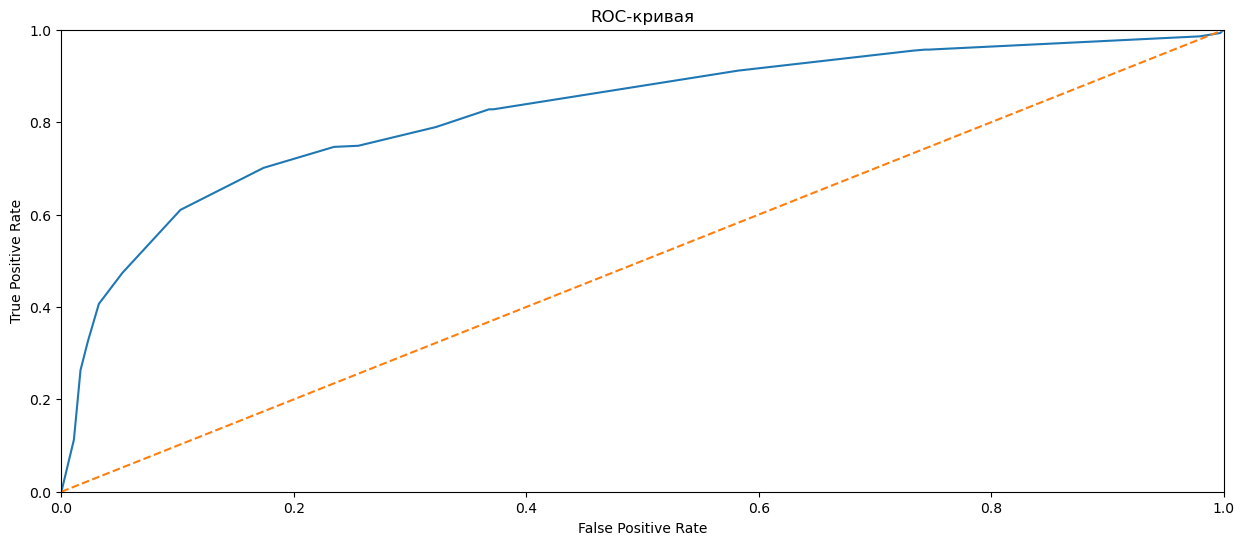

In [49]:
# Построим ROC-кривую

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Первая модель успешно прошла тест: f1-score равна 0.594, auc-roc равна 0.82. Судя по графику, модель обладает средней предсказательной способностью. 

In [50]:
# Random Forest Balanced test

predicted_test = best_model_rfc_balanced.predict(features_test)
probabilities_test = best_model_rfc_balanced.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('Accuracy:', accuracy_score(predicted_test, target_test))
print('F1-мера:', f1_score(target_test, predicted_test))
print('AUC-ROC', roc_auc_score(target_test, probabilities_one_test))

Accuracy: 0.8405
F1-мера: 0.6151990349819059
AUC-ROC 0.852033039154604


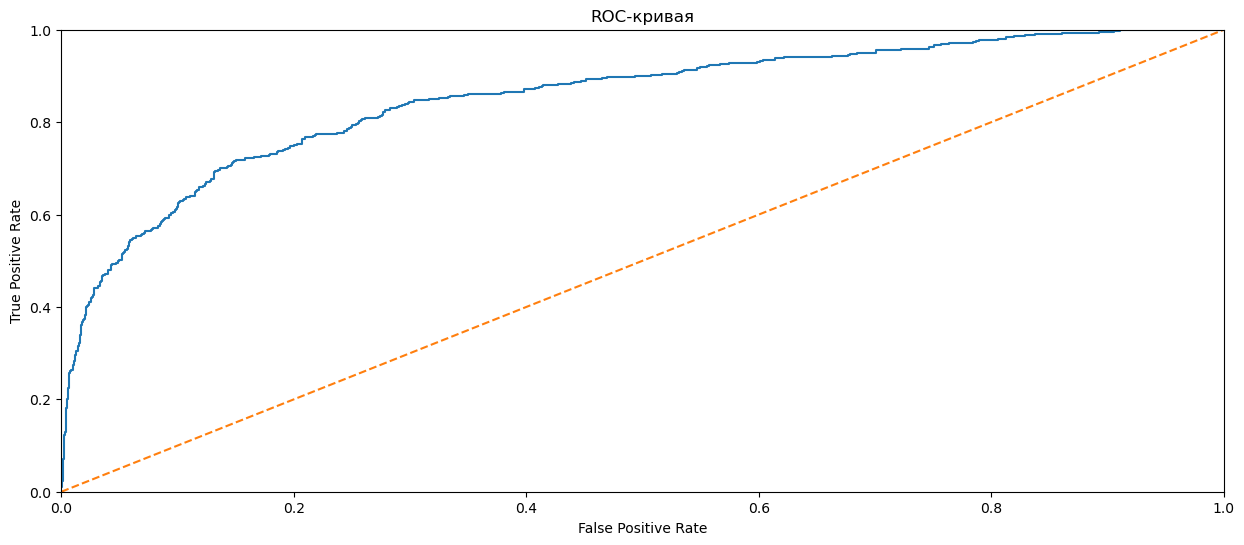

In [51]:
# Построим ROC-кривую

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Вторая модель также прошла тест, её показатели выше предыдущей модели:
f1-score = 0.615, auc-roc = 0.85. ROC-кривая расположена ближе к верхнему левому углу, соответственно предсказательная способность этой модели выше предыдущей. 

In [52]:
# Random Forest Upsampled test

predicted_test = best_model_rfc_upsampled.predict(features_test)
probabilities_test = best_model_rfc_upsampled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('Accuracy:', accuracy_score(predicted_test, target_test))
print('F1-мера:', f1_score(target_test, predicted_test))
print('AUC-ROC', roc_auc_score(target_test, probabilities_one_test))

Accuracy: 0.8115
F1-мера: 0.6109391124871001
AUC-ROC 0.8563927921170587


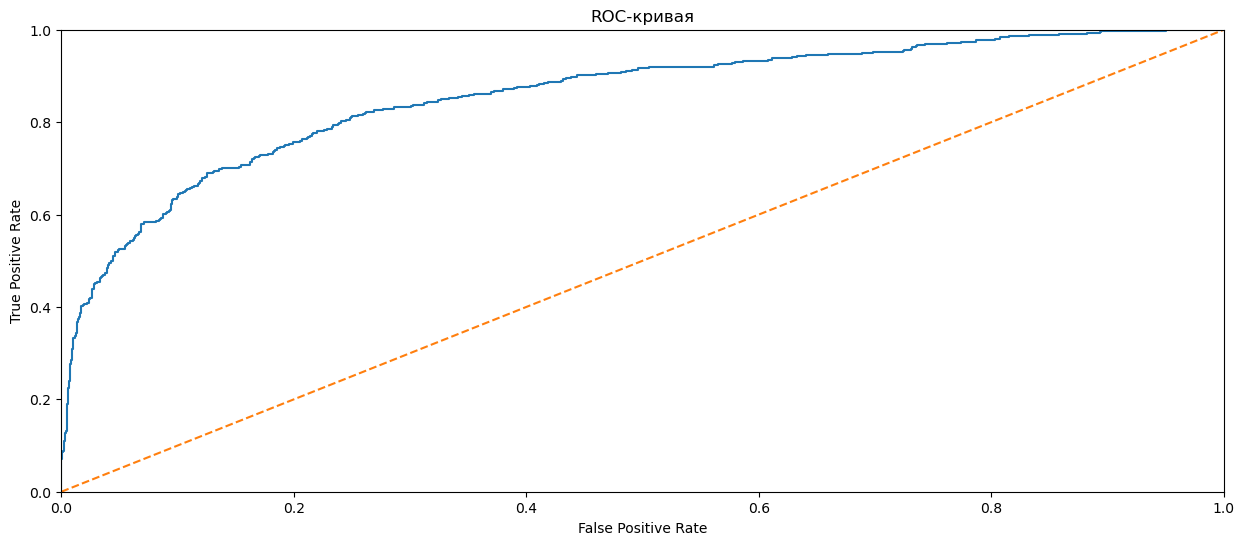

In [53]:
# Построим ROC-кривую

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Третья модель успешно прошла тестирование и показала F-1 меру 0.61, AUC-ROC 0.85. Судя по графику ROC-кривой, качество модели примерно такое же, как у предыдущей модели. 

In [54]:
# Random Forest Downsampled test

predicted_test = best_model_rfc_downsampled.predict(features_test)
probabilities_test = best_model_rfc_downsampled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print('Accuracy:', accuracy_score(predicted_test, target_test))
print('F1-мера:', f1_score(target_test, predicted_test))
print('AUC-ROC', roc_auc_score(target_test, probabilities_one_test))

Accuracy: 0.8115
F1-мера: 0.6109391124871001
AUC-ROC 0.8562839117100878


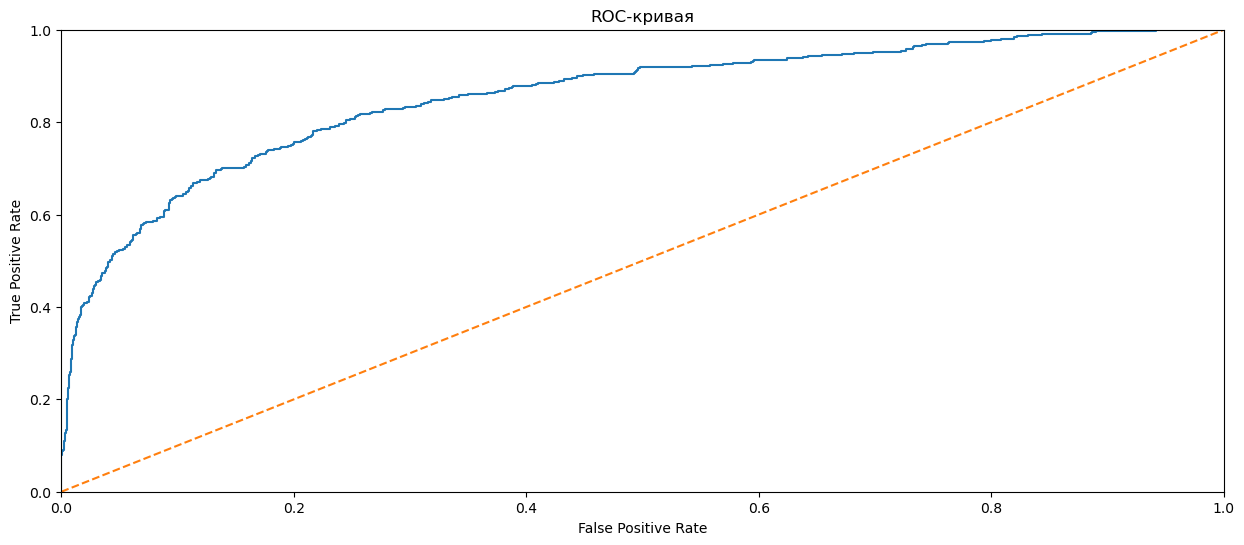

In [55]:
# Построим ROC-кривую

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Последняя модель тоже успешно прошла тестирование и показала результат, похожий на результат предыдущей модели: f1-score равна 0.61, ROC-AUC равна 0.85. График кривой демонстрирует хорошее качество модели. 

**Вывод:**

Все 4 модели успешно прошли тест. По итогам исследования наиболее качественной моделью стала модель Random Forest Balanced (модель случайного леса с примененным параметром class_weight = 'balanced'): f1-score = 0.615, auc-roc = 0.85

## Итоговый вывод

- В ходе работы был изучен набор данных, содержащий 10000 строк и 14 столбцов. В результате подготовки данных были заполнены пропуски, дубликатов не обнаружено. Названия столбцов приведены к нижнему регистру, ненужные для настоящего исследования столбцы были удалены. Категориальные признаки обработаны техникой One-Hot Encoding;
- Данные были разбиты на три выборки в отношении 3:1:1 - на обучающую, валидационную и тестовую соответственно. Размер обучающей выборки составляет 6000 строк, а валидационной и тестовой - по 2000 строки каждая. Для того, чтобы алгоритмам было легче обучать модели,  признаки были приведены к одному масштабу;
- В ходе исследования проверялось качество моделей трех типов: решающее дерево, случайный лес и логистическая регрессия. Гиперпараметры для моделей перебирались в цикле, чтобы найти среди них наиболее качественную. В результате обучения моделей на несбалансированной выборке получить модель с f1-score не менее 0.59 не удалось. 
- Для улучшения качества моделей были применены три способа борьбы с дисбалансом классов: взвешивание классов, увеличение и уменьшение выборки. 
- В ходе исследования качества моделей на сбалансированных выборках, достичь f1-score не менее 0.59 удалось нескольким моделям: Decision Tree Downsampled (F1-мера равна 0.6), Random Forest Balanced (F1-мера равна 0.61), Random Forest Upsampled (F1-мера равна 0.62), Random Forest Downsampled (F1-мера равна 0.615)
- Модели с самыми высокими показателями были проверены на тестовой выборке. По итогам финального тестирования наиболее качественной моделью стала Random Forest Balanced (модель случайного леса с примененным параметром class_weight = 'balanced'): f1-score = 0.615, auc-roc = 0.85 

Таким образом, мы получили модель машинного обучения, которая способна решить поставленную задачу классификации с помощью предоставленных исторических данных о поведении клиентов и расторжении договоров с банком. Теперь эту модель можно применять для того, чтобы спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.